<a href="https://colab.research.google.com/github/lisosoma/ml-test/blob/main/Model_students_upd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача. Построить модель прогнозирования факта сдачи теста

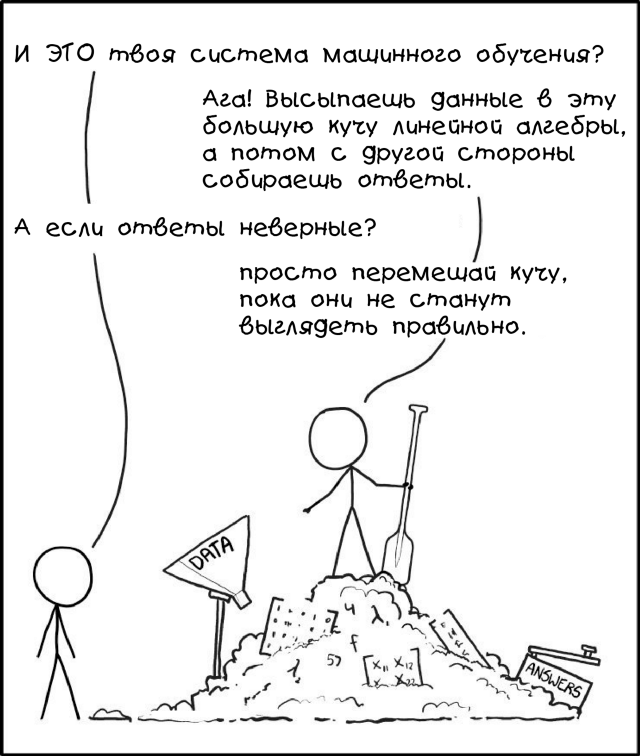

### Эссе

В результате изучения пайплайна, можно отметить следующие моменты, которые приводят к тому, что модель перестала работать:

- Столбцы `Unnamed: 0` и `Unnamed: 0.1` полностью повторяют значения индексов строк датафрейма, поэтому их необходимо удалить. Эти столбцы приводят к искажению данных, с которыми, к примеру, классификаторы Дерево решений или Случайный лес будут обучаться очень плохо и давать плохие предсказания.

- Не совсем понятно, зачем удаляется столбец `target` и рассматривается в качестве целевой переменной балл по тесту, если необходимо предсказывать факт сдачи теста, а не балл по тесту. И как видно из данных, высокий балл по тесту не всегда коррелирует с его сдачей. Поэтому в данной модели это также ошибка, причем нарушающая само условие задачи.

- Пропуски в данных заменяются на среднее. Но, как видно по датафрейму, здесь есть категориальные признаки, для которых среднее в принципе не существует, поэтому было бы разумнее заменять проспуски на моду. Причем, также можно отметить еще то, что в `y` пропуски не заполняются, что тоже неверно.

- Странно, что используется линейная регрессия, поскольку хотим предсказывать факт сдачи теста, то есть нужен классификатор, а не регрессор. И также можно заметить, что данные не имеют какой-то четкой линейной зависимости, если использовать `pandas_profiling`, то по матрицам ковариации видна очень слабая зависимость между `target` и другими переменными.

- В той части кода, где инжинирится новая переменная, используется среднее значение `target`, но `target` это переменная, принимающая значения только 0 и 1, поэтому лучше использовать моду. И эта переменная не используется для дальнейшего обучения в модели, потому что разделение на обучающую и тестовую выборки произошло ранее. Также в данном создании новой переменной используется столбцец `target` без замены пропусков значений в нем.

- В качестве исправлений для модели можно предложить следующие:

    1. предобработка данных, заключающаяся в удалении дублирующих столбцов;
    2. заменять пропуски в данных модой, а не медианой для категориальных признаков, для количественных можно оставить среднее в качестве замены пропуска;
    3. выбрать в качестве целевой переменной не балл по тесту (`posttest`), а переменную, отвечающую за факт сдачи теста (`target`);
    4. в качестве модели машинного обучения использовать классификатор. можно предложить в качестве классификатора, например, SVM или Random Forest, а в качестве метрики качества обученной модели использовать f1 метрику.
    5. провести кросс-валидацию модели, посмотреть на метрики, сделать выводы.

### Загружаем библиотеки

In [ ]:
import itertools
import numpy as np
import pandas as pd
import scipy

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline 

### Загружаем данные

In [ ]:
df = pd.read_csv('dataset.csv', sep=';')
print(df.shape)
df.head()

(2133, 12)


,Unnamed: 0,Unnamed: 0.1,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,posttest,target
0,0,0,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,72.0,1.0
1,1,1,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,79.0,0.0
2,2,2,ANKYI,Urban,Non-public,6OL,Standard,NaN,Male,Does not qualify,76.0,1.0
3,3,3,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,77.0,1.0
4,4,4,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,76.0,0.0


Посмотрим `ProfileReport`

In [ ]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Описание полей
* **school** - Код школы, в которой учится ученик  
* **school_setting** - Тип района в котором находится школа  
* **school_type** - Частная или нет школа  
* **classroom** - внутренний код класса, в котором проиходят занятия  
* **teaching_method** - является ли обучение экспериментальным  
* **n_student** - возраст ученика  
* **gender** - пол ученика  
* **lunch** - Является ли ученик слабозащищенной категорией населения  
* **posttest** - балл по тесту
* **target** - сдал или нет. 1- сдал.

### Удалим дублирующиеся столбцы, определим целевую переменную, заполним пропуски в данных

In [ ]:
# удаление дублирующихся столбцов

df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Unnamed: 0.1'], axis=1)
df

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,posttest,target
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,72.0,1.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,79.0,0.0
2,ANKYI,Urban,Non-public,6OL,Standard,NaN,Male,Does not qualify,76.0,1.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,77.0,1.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,76.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2128,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Does not qualify,55.0,NaN
2129,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,46.0,NaN
2130,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,51.0,NaN
2131,ZOWMK,Urban,Public,ZBH,Standard,30.0,Male,Qualifies for reduced/free lunch,53.0,NaN


In [ ]:
# заполнение пропусков

# если признак категориальный, то заполняем модой
categorical_features = df.columns[df.dtypes == 'object']

for column in categorical_features:
    if False in df[column].isna(): 
        df[column].fillna(df[column].mode()[0], inplace=True)

# если признак количественный, то заполняем средним
quantitative_features = df.columns[df.dtypes == 'float64']

for column in quantitative_features:
    if False in df[column].isna() and column != 'target': 
        df[column].fillna(df[column].mean(), inplace=True)
        
# заполняем пропуски в целевой переменной
df['target'].fillna(df['target'].mode()[0], inplace=True)

#### Заинжинирим новую переменную
пол*возраст
для каждой комбинации посчитаем weight of evidence и будем его использовать в модели

In [ ]:
for i in df.gender.unique():
    for j in df.n_student.unique():
        l=df.loc[(df.gender==i) & (df.n_student>=j)]
        woe=l.target.sum()/(l.target.count() - df.target.mode()[0] - 1) # здесь заменили среднее на моду
        df.loc[(df.gender==i) & (df.n_student>=j), 'woe_agegender']=woe

В качестве целевой переменной будем использовать `target`.

In [ ]:
X = df.drop(['target'], axis=1)
y = df['target']

### Разобьем выборку на train / test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
X_train.shape, X_test.shape

((1599, 10), (534, 10))

-----------

Так как в качестве целевой переменной рассматривается бинарная переменная `target`, то в качестве модели машинного обучения будет использовать классификатор. Попробуем SVM.

### Дальше накинем one-hot encoding

In [ ]:
class ClassificationEncoder(BaseEstimator):
    def __init__(self):
        self.svm = SVC(kernel = 'linear')
        self.encoders = {}
    
    
    def fit(self, X, y):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X[col])
            self.encoders[col] = le
            
        self.svm.fit(X_enc, y)
        
        
        # считаем значимость
        y_pred = self.svm.predict(X_enc)
        sse = np.sum((y_pred - y) ** 2, axis=0) / float(X_enc.shape[0] - X_enc.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.pinv(np.dot(X_enc.T, X_enc))))])

        self.t = self.svm.coef_ / se
        self.p = 2 * (1 - scipy.stats.t.cdf(np.abs(self.t), y.shape[0] - X_enc.shape[1]))

        
        return self
    
    def predict(self, X):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            X_enc[col] = self.encoders[col].transform(X[col])
            
        y_pred = self.svm.predict(X_enc)
        
        return y_pred
    
    def score(self, X, y):        
        y_pred = self.predict(X)
        
        return f1_score(y, y_pred)
    
    # функция, осуществляющая кросс-валидацию модели
    def validate(self, X, y):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X[col])
            
        return cross_validate(self.svm, X_enc, y, cv=5)['test_score']

In [ ]:
df.target.unique()

array([1., 0.])

In [ ]:
%%time
svm = ClassificationEncoder()
svm.fit(X_train, y_train)

Wall time: 889 ms


ClassificationEncoder()

In [ ]:
print('TRAIN F1:', svm.score(X_train, y_train))
print('TEST F1:', svm.score(X_test, y_test))

TRAIN F1: 0.5778288340034464
TEST F1: 0.549828178694158


#### Как видно, f1 метрика на тестовых данных не сильно хуже, чем на обучающих, поэтому модель в целом построена хорошо.

Улучшим модель, исключив из данных незначимые факторы.

In [ ]:
for p_val, factor in itertools.zip_longest(np.array(svm.p[0]), np.array(X.columns)):
    print(factor, ' - ', round(p_val, 6))

school  -  0.0
school_setting  -  0.0
school_type  -  0.000513
classroom  -  0.0
teaching_method  -  0.002334
n_student  -  0.51326
gender  -  0.0
lunch  -  0.0
posttest  -  0.0
woe_agegender  -  6e-06


удалим факторы у которых pvalue = 0 и перевзвесим коэффициенты

In [ ]:
sign = [f for p, f in itertools.zip_longest(np.array(svm.p[0]), np.array(X.columns)) if p == 0.0]
sign

['school', 'classroom', 'lunch']

Обучим модель без учета незначимых факторов.

In [ ]:
%%time
svm2 = ClassificationEncoder()
svm2.fit(X_train.drop(sign, axis=1), y_train)

Wall time: 634 ms


ClassificationEncoder()

In [ ]:
print('TRAIN F1 after drop insignificant:', 
      svm2.score(X_train.drop(sign, axis=1), y_train))
print('TEST F1 after drop insignificant', 
      svm2.score(X_test.drop(sign, axis=1), y_test))

TRAIN F1 after drop insignificant: 0.5848648648648649
TEST F1 after drop insignificant 0.5533333333333333


Как видно, метрики стали немного лучше.

### Попробуем другие модели

In [ ]:
class ClassificationEncoder2(BaseEstimator):
    def __init__(self, cl):
        self.cl = cl
        self.encoders = {}
    
    
    def fit(self, X, y):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X[col])
            self.encoders[col] = le
            
        self.cl.fit(X_enc, y)
        
        return self
    
    def predict(self, X):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            X_enc[col] = self.encoders[col].transform(X[col])
            
        y_pred = self.cl.predict(X_enc)
        
        return y_pred
    
    
    def score(self, X, y):        
        y_pred = self.predict(X)
        
        return f1_score(y, y_pred)
    
    
    # функция, осуществляющая кросс-валидацию модели
    def validate(self, X, y):
        X_enc = X.copy()
        categorical_features = X.columns[X.dtypes == 'object']
        
        for col in categorical_features:
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X[col])
            
        return cross_validate(self.cl, X_enc, y, cv=5)['test_score']

- RandomForest

In [ ]:
%%time
rfc = ClassificationEncoder2(RandomForestClassifier())
rfc.fit(X_train, y_train)

Wall time: 246 ms


ClassificationEncoder2(cl=RandomForestClassifier())

In [ ]:
print('TRAIN F1:', rfc.score(X_train, y_train))
print('TEST F1:', rfc.score(X_test, y_test))

TRAIN F1: 0.8762254901960784
TEST F1: 0.4868913857677902


Можно видеть, что метрика на тестах гораздо хуже, чем на обучающей выборке.

- SVM с другой ядерной функцией

In [ ]:
%%time
svm3 = ClassificationEncoder2(SVC(kernel = 'poly', degree = 4))
svm3.fit(X_train, y_train)

Wall time: 105 ms


ClassificationEncoder2(cl=SVC(degree=4, kernel='poly'))

In [ ]:
print('TRAIN F1:', svm3.score(X_train, y_train))
print('TEST F1:', svm3.score(X_test, y_test))

TRAIN F1: 0.6453703703703704
TEST F1: 0.6164772727272727


Здесь метрики немного лучше, чем при использовании линейной ядерной функции для SVM.

### Кросс-валидация

Проведем кросс-валидацию для исправленной модели.

In [ ]:
svm.validate(X, y)

array([0.48711944, 0.52459016, 0.43793911, 0.47183099, 0.47887324])

Как видим, метрики в целом не сильно отличаются друг от друга. Посмотрим на кросс-валидацию модели, в которой удалены незначимые признаки.

In [ ]:
svm2.validate(X.drop(sign, axis=1), y)

array([0.45901639, 0.50819672, 0.44262295, 0.49295775, 0.5       ])

Метрики чуть лучше.

In [ ]:
rfc.validate(X, y)

array([0.4941452 , 0.47540984, 0.41217799, 0.44600939, 0.49530516])

In [ ]:
svm3.validate(X, y)

array([0.5058548 , 0.42388759, 0.43325527, 0.48591549, 0.51877934])

Как видим, метрики у других моделей не сильно отличаются от метрик модели SVC с линейной ядерной функцией. 